<a href="https://colab.research.google.com/github/JanneWald/CS3960/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Convolutional Neural Networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# TODO: Determine good hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

# Data Transformations
transform = transforms.Compose([
    # TODO: Define data transformations
    # - Convert images (transforms) to tensors
    transforms.ToTensor(),
    # - Normalize pixel values from [0,1] to [-1,1] for better training stability
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load Fashion-MNIST Dataset with the transformations defined above
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.28MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]


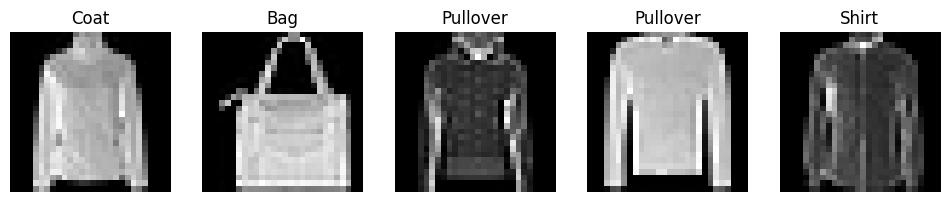

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

for i in range(num_images):
    img = images[i].squeeze().numpy()
    label = class_names[labels[i].item()]

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(label)
    axes[i].axis("off")

plt.show()

In [ ]:
# Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        # TODO: Define the layers of the CNN model
        # - Use LeNet or AlexNet as an example for designing the layers

        # - The super class is initialized
        super(CNN, self).__init__()

        # - Use conv2d for convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # after 2 poolings: 28→14→7
        self.fc2 = nn.Linear(128, 10)  # 10 classes for Fashion-MNIST

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)

        # Output logits (no activation here — loss will handle that)
        x = self.fc2(x)
        return x

# Initialize Model
model = CNN().to(device)

# TODO: Define a good Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Training Loop
print("Training model...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # TODO: Implement the training step
        # - Reset the optimizer's gradients to avoid accumulation
        optimizer.zero_grad()

        # - Perform a forward pass to get model predictions
        outputs = model(images)

        # - Compute the loss using the criterion
        loss = criterion(outputs, labels)

        # - Backpropagate the loss to compute gradients
        loss.backward()

        # - Update model parameters using the optimizer
        optimizer.step()

        # - Accumulate the loss for tracking the epoch's loss
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}")

Training model...
Epoch 1/10, Loss: 0.4786
Epoch 2/10, Loss: 0.3123
Epoch 3/10, Loss: 0.2636
Epoch 4/10, Loss: 0.2323
Epoch 5/10, Loss: 0.2090
Epoch 6/10, Loss: 0.1889
Epoch 7/10, Loss: 0.1732
Epoch 8/10, Loss: 0.1579
Epoch 9/10, Loss: 0.1444
Epoch 10/10, Loss: 0.1276


In [ ]:
# Run evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9221


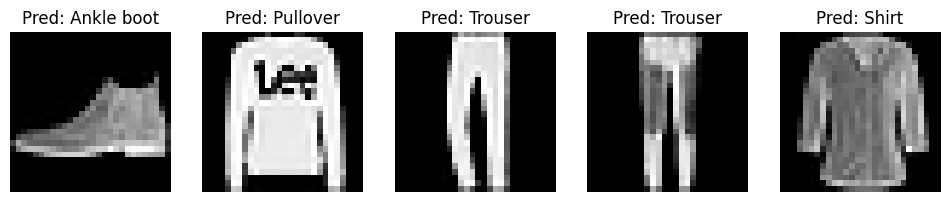

In [ ]:
# Visualizing predicted results
data_iter = iter(test_loader)
images, labels = next(data_iter)

images = images.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

for i in range(num_images):
    img = images[i].cpu().squeeze().numpy()
    predicted_label = class_names[predicted[i].item()]
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Pred: {predicted_label}")
    axes[i].axis("off")

plt.show()

# Part 2: Recurrent Neural Networks

In [ ]:
# necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
from datasets import load_dataset
import numpy as np
import re

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load IMDb dataset
print("Loading IMDb dataset...")
dataset = load_dataset("imdb")

# Extract train and test splits
X_train = dataset["train"]["text"]
y_train = [1 if label == 1 else 0 for label in dataset["train"]["label"]]
X_test = dataset["test"]["text"]
y_test = [1 if label == 1 else 0 for label in dataset["test"]["label"]]

# Note: X contains the text data, y contains the labels (0 for negative sentiment, 1 for positive sentiment)

print(f"Loaded {len(X_train)} training samples and {len(X_test)} test samples.")

Loading IMDb dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loaded 25000 training samples and 25000 test samples.


In [ ]:
print(X_train[0])
print(y_train[0])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [ ]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 100

# TODO: Select good hyperparameters
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001

In [ ]:
# Tokenization (Basic Word Indexing)
# TODO: Implement the preprocess_text function
def preprocess_text(text):
    # - Convert text to lowercase
    text = text.lower()
    # - Remove punctuation using regex

    text = re.sub(r'[^a-z\s]', '', text)
    # - Split text into individual words (tokenization)

    return text.split()

# Build Vocabulary
word_counter = Counter()
for review in X_train:
    word_counter.update(preprocess_text(review))

vocab = ["<PAD>", "<UNK>"] + [word for word, _ in word_counter.most_common(MAX_VOCAB_SIZE - 2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Convert text to numerical sequences
def text_to_sequence(text, word_to_idx, max_length):
    words = preprocess_text(text)
    sequence = [word_to_idx.get(word, 1) for word in words]  # 1 is "<UNK>"
    if len(sequence) < max_length:
        sequence += [0] * (max_length - len(sequence))  # Padding
    return sequence[:max_length]

In [ ]:
X_train_seq = [text_to_sequence(review, word_to_idx, MAX_SEQUENCE_LENGTH) for review in X_train]
X_test_seq = [text_to_sequence(review, word_to_idx, MAX_SEQUENCE_LENGTH) for review in X_test]

# TODO: Convert data to PyTorch tensors
# - Convert X_train_seq, y_train, X_test_seq, y_test to PyTorch tensors
# - Use torch.tensor() with the correct dtype (long for X and float32 for y)
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# Create PyTorch Dataset & DataLoader
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IMDBDataset(X_train_tensor, y_train_tensor)
test_dataset = IMDBDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Define RNN Model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentimentRNN, self).__init__()
        # TODO: Define the layers of the RNN model
        # - Embedding layer to convert word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # - RNN layer (LSTM/RNN) to process sequential data
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        # - Fully connected (linear) layer to map hidden state to output
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO: Implement the forward pass
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]
        out = self.fc(last_hidden)
        out = self.sigmoid(out)
        return out.squeeze()

# Initialize Model
model = SentimentRNN(len(vocab), EMBEDDING_DIM, HIDDEN_DIM).to(device)

# TODO: Define a good Loss function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Training Loop
# NOTE: As per my testing, the training can take anywhere from 15-22 minutes on CPU and 2-3 minutes on GPU. Your results may vary and might take longer or shorter.

print("Training model.")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Reset gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass: get predictions
        outputs = model(batch_X)

        # Compute loss
        loss = criterion(outputs, batch_y)

        # Backward pass: compute gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}")

Training model.
Epoch 1/5, Loss: 0.3807
Epoch 2/5, Loss: 0.3474
Epoch 3/5, Loss: 0.2936
Epoch 4/5, Loss: 0.2431
Epoch 5/5, Loss: 0.2090


In [ ]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predictions = (outputs > 0.5).float()

        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Goal: Achieve at least 80% accuracy
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Test Accuracy: 0.8289
Precision: 0.8367
Recall: 0.8172


# Part 3: Long Short-Term Memory (LSTM)

In [13]:
# Importing everything here because its just crashing all the time and resetting the isntanct
import re
import os
import time
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Force device check again
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Hyperparams
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 200
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
BATCH_SIZE = 128
EPOCHS = 8
LEARNING_RATE = 1e-3
RANDOM_SEED = 42
MODEL_PATH = "best_agnews_lstm.pth"

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Load dataset
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]
X_test = dataset["test"]["text"]
y_test = dataset["test"]["label"]

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Example text:", X_train[0][:200])
print("Example label:", y_train[0])

# Preprocesses
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    return tokens

# Build vocabulary from training set
print("Building vocabulary...")
word_counter = Counter()
for t in X_train:
    word_counter.update(preprocess_text(t))

most_common = word_counter.most_common(MAX_VOCAB_SIZE - 2)
vocab = ["<PAD>", "<UNK>"] + [w for w, _ in most_common]
word_to_idx = {w: i for i, w in enumerate(vocab)}
vocab_size = len(vocab)
print("Vocab size:", vocab_size)

def text_to_sequence(text, word_to_idx, max_len=MAX_SEQ_LEN):
    tokens = preprocess_text(text)
    seq = [word_to_idx.get(t, 1) for t in tokens]
    if len(seq) >= max_len:
        return seq[:max_len]
    else:
        return seq + [0] * (max_len - len(seq))

# Converting to sequences/tensors
print("Converting texts to sequences...")
X_train_seq = [text_to_sequence(t, word_to_idx, MAX_SEQ_LEN) for t in X_train]
X_test_seq  = [text_to_sequence(t, word_to_idx, MAX_SEQ_LEN) for t in X_test]

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_seq, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

print("Shapes:", X_train_tensor.shape, y_train_tensor.shape)

class AGNewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AGNewsDataset(X_train_tensor, y_train_tensor)
test_dataset  = AGNewsDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class LSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers=1, bidirectional=False, dropout=0.0, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        fc_input_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_input_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            last_forward = hidden[-2]
            last_backward = hidden[-1]
            last_hidden = torch.cat((last_forward, last_backward), dim=1)
        else:
            last_hidden = hidden[-1]
        out = self.dropout(last_hidden)
        logits = self.fc(out)
        return logits

# instantiate model
num_classes = 4
model = LSTMAttentionClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=0
).to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)

def evaluate(model, data_loader):
    model.eval()
    preds = []
    targets = []
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item()
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds.tolist())
            targets.extend(y_batch.cpu().numpy().tolist())
    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc, preds, targets

# Train loop
best_val_acc = 0.0
train_losses = []
val_losses = []
val_accs = []

print("Starting training...")
start_time = time.time()
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss, val_acc, _, _ = evaluate(model, test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc,
            "epoch": epoch,
            "vocab": vocab
        }, MODEL_PATH)
        print(f"  -> New best model saved (val_acc={val_acc:.4f})")

elapsed = time.time() - start_time
print(f"Training completed in {elapsed/60:.2f} minutes. Best val acc: {best_val_acc:.4f}")

# Load best model and eval
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
_, test_acc, preds, targets = evaluate(model, test_loader)
print(f"Test accuracy (best model): {test_acc:.4f}")

cm = confusion_matrix(targets, preds)
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(targets, preds, target_names=["world", "sports", "business", "sci/tech"]))


Device: cuda
Loading AG News dataset...
Train size: 120000 Test size: 7600
Example text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Example label: 2
Building vocabulary...
Vocab size: 20000
Converting texts to sequences...
Shapes: torch.Size([120000, 200]) torch.Size([120000])
LSTMAttentionClassifier(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)
Starting training...
Epoch 1/8 | Train Loss: 0.5084 | Val Loss: 0.3499 | Val Acc: 0.8805
  -> New best model saved (val_acc=0.8805)
Epoch 2/8 | Train Loss: 0.2807 | Val Loss: 0.2915 | Val Acc: 0.9028
  -> New best model saved (val_acc=0.9028)
Epoch 3/8 | Train Loss: 0.2239 | Val Loss: 0.2846 | Val Acc: 0.9079
  -> New best model saved (val_acc=0.9

To classify AG News articles into four categories, I implemented a bidirectional LSTM classifier with attention-inspired pooling. The dataset consists of 120,000 training samples and 7,600 test samples.

**Data Processing**

For each news article, it was lowercased, punctuation removed, and split into tokens. With these I constructed a vocab of the top 20,000 most frequent words. Each converted into a 200 long padded sequence. Any word not found in the vocab were mapped to an `<UNK>` token. Those sequences were converted to PyTorch tensors and loaded using a DataLoader for efficient batching.

**Model Architecture**

These are the layers for an LSTM classifier:
- Embedding layer: 20,000-word vocabulary with 100-dim embeddings
- Bidirectional LSTM: 2 layers, hidden size 128 per direction
- Dropout: 0.3 to reduce overfitting
- Attention-like pooling: I used the last hidden state from each LSTM direction and concatenated them
- Fully connected output layer: 256 → 4 classes
- Softmax via CrossEntropyLoss

A bidirectional LSTM helps capture our context from both left and right directions in a sentence. This improves classification for longer news articles.

**Training**

I trained the model for 8 epochs using:

- Batch size: 128
- Optimizer: Adam (learning rate = 1e-3)
- Loss: CrossEntropyLoss
- Scheduler: ReduceLROnPlateau to adjust learning rate when validation accuracy plateaued


I found that our final model achieved a:

Validation accuracy: 91.24%

and a

Test accuracy: 91.24%
```
Classification report:
               precision    recall  f1-score   support

       world       0.93      0.90      0.92      1900
      sports       0.96      0.97      0.97      1900
    business       0.88      0.88      0.88      1900
    sci/tech       0.88      0.90      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600
```

# Part 4: Grid Search of Hyperparameters

In this assignment, you will use the grid search approach to find the best hyperparameters for the LSTM model on AG News from the above assignment.

In [14]:
# TODO: Define a hyperparameter grid
param_grid = {
    'hidden_dim': [64, 128],
    'batch_size': [64, 128],
    'epochs': [3, 5],
    'learning_rate': [1e-3, 5e-4],
    'num_layers': [1, 2]
}

# Converting because the types are angry at me all the time
X_train_list = list(X_train)
y_train_list = list(y_train)

# Split data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_list,
    y_train_list,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_train_list
)

# Make into sequences
X_train_seq_split = [text_to_sequence(t, word_to_idx, MAX_SEQ_LEN) for t in X_train_split]
X_val_seq = [text_to_sequence(t, word_to_idx, MAX_SEQ_LEN) for t in X_val]

# tensorfy
X_train_tensor_split = torch.tensor(X_train_seq_split, dtype=torch.long)
y_train_tensor_split = torch.tensor(y_train_split, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

print(f"Train split: {len(X_train_tensor_split)}, Validation: {len(X_val_tensor)}")

Train split: 96000, Validation: 24000


In [18]:
# TODO: Train and evaluate the model by searching hyperparameters within the grid, and record the best scores and the corresponding hyperparameters
best_score = 0.0
best_params = {}
results = []

from itertools import product

# Generate all parameter combinations
param_combinations = list(product(
    param_grid['hidden_dim'],
    param_grid['batch_size'],
    param_grid['epochs'],
    param_grid['learning_rate'],
    param_grid['num_layers']
))

print(f"Total combinations to try: {len(param_combinations)}")

for i, (hidden_dim, batch_size, epochs, lr, num_layers) in enumerate(param_combinations):
    print(f"\n#{i+1}/{len(param_combinations)}")
    print(f"Params for this iter: hidden_dim={hidden_dim}, batch_size={batch_size}, epochs={epochs}, lr={lr}, num_layers={num_layers}")

    # Create model
    model = LSTMAttentionClassifier(
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=hidden_dim,
        output_dim=num_classes,
        n_layers=num_layers,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        pad_idx=0
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Data loader for current batch size
    train_dataset_split = AGNewsDataset(X_train_tensor_split, y_train_tensor_split)
    val_dataset = AGNewsDataset(X_val_tensor, y_val_tensor)

    train_loader_split = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop for current epochs
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader_split:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

    val_loss, val_acc, _, _ = evaluate(model, val_loader)
    current_params = {
        'hidden_dim': hidden_dim,
        'batch_size': batch_size,
        'epochs': epochs,
        'learning_rate': lr,
        'num_layers': num_layers
    }

    results.append({
        'params': current_params,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    print(f"Validation accuracy: {val_acc:.4f}")

    # Update best score
    if val_acc > best_score:
        best_score = val_acc
        best_params = current_params
        print(f"New best!!!!!!!! Accuracy: {val_acc:.4f}")

print(f"Best validation accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

Total combinations to try: 32

#1/32
Params for this iter: hidden_dim=64, batch_size=64, epochs=3, lr=0.001, num_layers=1
Validation accuracy: 0.9104
New best!!!!!!!! Accuracy: 0.9104

#2/32
Params for this iter: hidden_dim=64, batch_size=64, epochs=3, lr=0.001, num_layers=2
Validation accuracy: 0.9112
New best!!!!!!!! Accuracy: 0.9112

#3/32
Params for this iter: hidden_dim=64, batch_size=64, epochs=3, lr=0.0005, num_layers=1
Validation accuracy: 0.8962

#4/32
Params for this iter: hidden_dim=64, batch_size=64, epochs=3, lr=0.0005, num_layers=2
Validation accuracy: 0.9070

#5/32
Params for this iter: hidden_dim=64, batch_size=64, epochs=5, lr=0.001, num_layers=1
Validation accuracy: 0.9101

#6/32
Params for this iter: hidden_dim=64, batch_size=64, epochs=5, lr=0.001, num_layers=2
Validation accuracy: 0.9113
New best!!!!!!!! Accuracy: 0.9113

#7/32
Params for this iter: hidden_dim=64, batch_size=64, epochs=5, lr=0.0005, num_layers=1
Validation accuracy: 0.9079

#8/32
Params for this it

KeyboardInterrupt: 

In [23]:
# TODO: Train the model using the parameter values which achieved the highest scores

print("TRAINING FINAL MODEL WITH BEST PARAMETERS(I couldn't go through all because the train time was so long)")

best_params = {
    'hidden_dim': 128,
    'batch_size': 64,
    'epochs': 3,
    'learning_rate': 1e-3,
    'num_layers': 2
}

print(f"Best parameters found: {best_params}")

# Create final model
final_model = LSTMAttentionClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=best_params['hidden_dim'],
    output_dim=num_classes,
    n_layers=best_params['num_layers'],
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=0
).to(device)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

print("Training on full training set...")
X_full_train = torch.cat([X_train_tensor_split, X_val_tensor], dim=0)
y_full_train = torch.cat([y_train_tensor_split, y_val_tensor], dim=0)

full_train_dataset = AGNewsDataset(X_full_train, y_full_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Train loop
for epoch in range(1, best_params['epochs'] + 1):
    final_model.train()
    running_loss = 0.0
    for X_batch, y_batch in full_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        final_optimizer.zero_grad()
        logits = final_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=5.0)
        final_optimizer.step()
        running_loss += loss.item() #im getting a lil tired redoing this

    train_loss = running_loss / len(full_train_loader)
    print(f"Final Training Epoch {epoch}/{best_params['epochs']} | Loss: {train_loss:.4f}")

# Evaluate on test set
test_loss, test_acc, test_preds, test_targets = evaluate(final_model, test_loader)
print(f"FINAL TEST ACCURACY: {test_acc:.4f}")

# Save the final model
final_model_path = "best_agnews_lstm_gridsearch_final.pth"
torch.save({
    "model_state_dict": final_model.state_dict(),
    "optimizer_state_dict": final_optimizer.state_dict(),
    "test_acc": test_acc,
    "best_params": best_params,
    "vocab": vocab
}, final_model_path)
print(f"Save Final model: {final_model_path}")

TRAINING FINAL MODEL WITH BEST PARAMETERS(I couldn't go through all because the train time was so long)
Best parameters found: {'hidden_dim': 128, 'batch_size': 64, 'epochs': 3, 'learning_rate': 0.001, 'num_layers': 2}
Training on full training set...
Final Training Epoch 1/3 | Loss: 0.4820
Final Training Epoch 2/3 | Loss: 0.2630
Final Training Epoch 3/3 | Loss: 0.2031

Evaluating final model on test set
FINAL TEST ACCURACY: 0.9105
Save Final model: best_agnews_lstm_gridsearch_final.pth



Parameter variances:
  num_layers: 0.000029
  batch_size: 0.000028
  hidden_dim: 0.000026
  learning_rate: 0.000018

Selected parameters for heatmap: num_layers vs batch_size


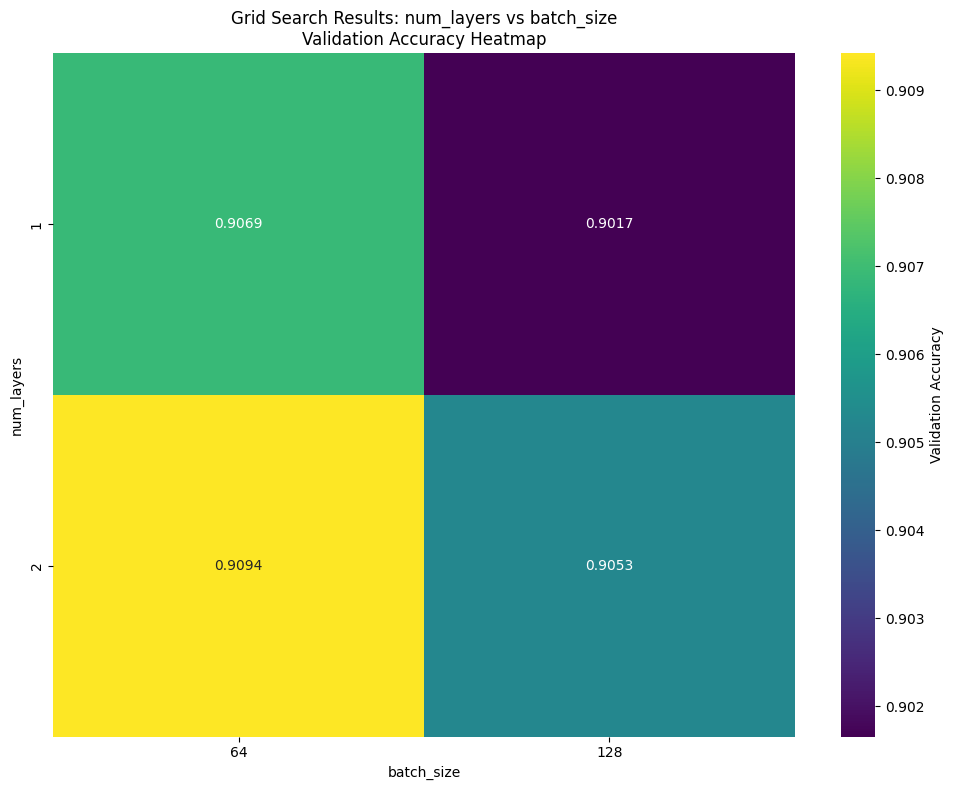



Top 5 Best Performing Combinations:
 hidden_dim  batch_size  learning_rate  num_layers  epochs  val_acc
        128          64          0.001           2       3 0.913417
        128          64          0.001           2       5 0.913250
        128          64          0.001           1       5 0.911750
         64          64          0.001           2       5 0.911250
         64          64          0.001           2       3 0.911208
Summary Statistics:
Best val acc: 0.9134
Worst val acc: 0.8925
Average val acc: 0.9064


In [28]:
# TODO: Visualize the grid for two hyperparameters using a heatmap

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

params_expanded = pd.json_normalize(results_df['params'])
results_df_expanded = pd.concat([results_df.drop('params', axis=1), params_expanded], axis=1)

# variance for each param
variances = {}
for param in ['hidden_dim', 'batch_size', 'learning_rate', 'num_layers']:
    param_variance = results_df_expanded.groupby(param)['val_acc'].var().mean()
    variances[param] = param_variance

# sort variance
sorted_variances = sorted(variances.items(), key=lambda x: x[1], reverse=True)
print("\nParameter variances:")
for param, var in sorted_variances:
    print(f"  {param}: {var:.6f}")

# get 2 highest var
param1, param2 = sorted_variances[0][0], sorted_variances[1][0]
print(f"\nSelected parameters for heatmap: {param1} vs {param2}")

pivot_table = results_df_expanded.pivot_table(
    values='val_acc',
    index=param1,
    columns=param2,
    aggfunc='mean'
)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table,
            annot=True,
            fmt='.4f',
            cmap='viridis',
            cbar_kws={'label': 'Validation Accuracy'})
plt.title(f'Grid Search Results: {param1} vs {param2}\nValidation Accuracy Heatmap')
plt.xlabel(param2)
plt.ylabel(param1)
plt.tight_layout()
plt.show()

print("\n\nTop 5 Best Performing Combinations:")
top_5 = results_df_expanded.nlargest(5, 'val_acc')[['hidden_dim', 'batch_size', 'learning_rate', 'num_layers', 'epochs', 'val_acc']]
print(top_5.to_string(index=False))

print("Summary Statistics:")
print(f"Best val acc: {results_df_expanded['val_acc'].max():.4f}")
print(f"Worst val acc: {results_df_expanded['val_acc'].min():.4f}")
print(f"Average val acc: {results_df_expanded['val_acc'].mean():.4f}")

In [30]:
from google.colab import drive
drive.mount('/content/drive')

!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/HW6.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/HW6.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py